# Data analysis of the glacier model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('../data/sv_cf_squared_velocity.npz')
print(list(data.keys()))


['inputs', 'uout', 'jac_u', 'jac_beta']


In [7]:
def vis_field(field):
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(field, cmap='rainbow', origin='lower', aspect='auto', interpolation=None)
    ax.set_xlabel('Time')
    ax.set_ylabel('Locations')
    cbar = plt.colorbar(im)
    

    plt.show()

def vis_train(logger):

    train_loss = logger['train_loss']
    val_loss = logger['val_loss']
    fig, ax = plt.subplots(1,2)
    ax[0].plot(train_loss, label='Train loss')
    ax[0].plot(val_loss, label='Validation loss')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss (forward + adj)")
    ax[0].legend()

    ax[1].plot(logger['val_adj_loss'], label='Validation Adj Loss')
    ax[1].legend()
    for a in ax:
        a.set_box_aspect(4.8/6.4)
    plt.show()
    return fig




-9.155644155780245e-07 1.0368458171625383e-06
(10000, 159) (10000, 80) (10000, 79) (10000, 80)
340.97805491


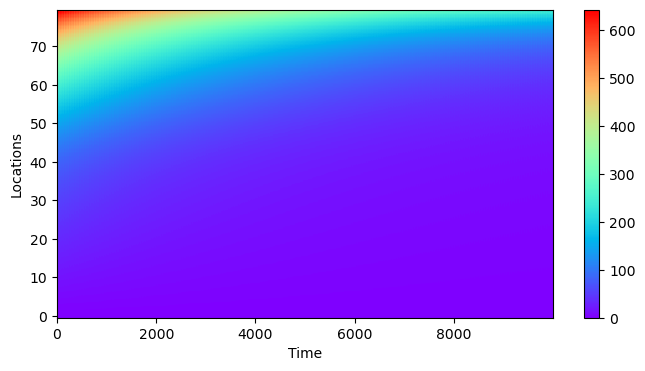

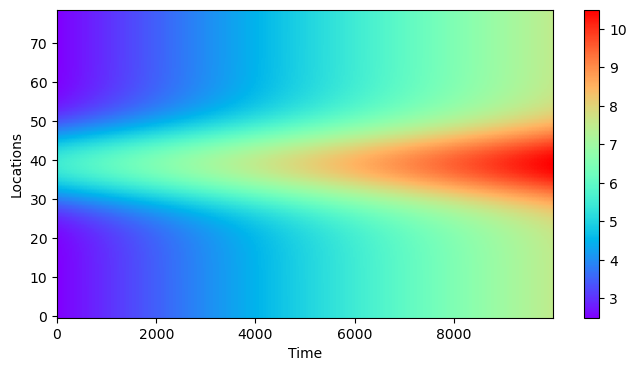

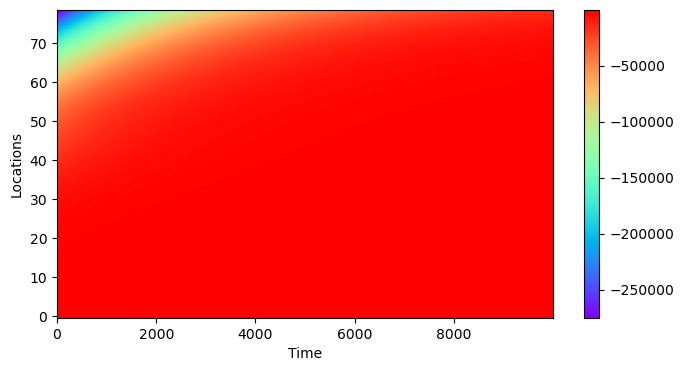

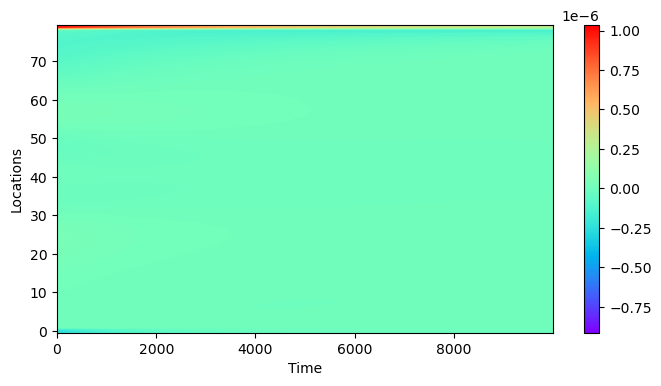

/var/folders/vc/kzz6d9bd797_jrkvtf6dm2l40000gn/T/ipykernel_38934/1228179545.py:13: RuntimeWarning: invalid value encountered in log
  vis_field(np.log(jrav).T)


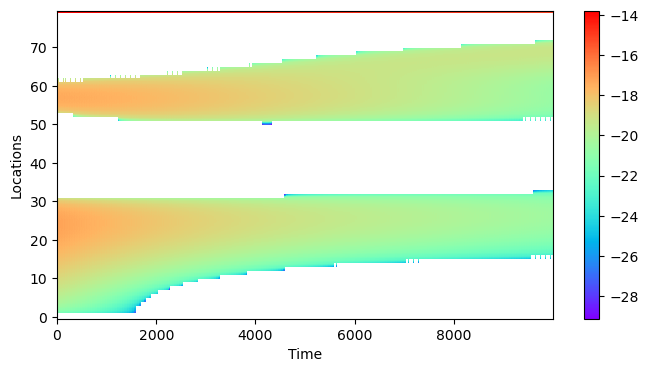

In [47]:


inputs = data['inputs']
uout = data['uout']
j_beta = data['jac_beta']
jrav = data['jac_u']

print(jrav.min(), jrav.max())
print(inputs.shape, uout.shape, j_beta.shape, jrav.shape)
print(inputs[0,79])
vis_field(inputs[:,:80].T)
vis_field(inputs[:,-79:].T)
vis_field(j_beta.T)
vis_field(jrav.T)
vis_field(np.log(jrav).T)

# print(jrav.shape, j_beta.shape)
# jrav = np.concatenate([jrav, j_beta[..., np.newaxis]], axis=-1)

# jcobian = jrav[10]
# norm_v = np.linalg.norm(jcobian, axis=-2)
# print(norm_v)

# fig, ax = plt.subplots()
# ax.bar(np.arange(len(norm_v)), norm_v)
# ax.set_xlabel('Input IDs')
# ax.set_ylabel('Norms')
# ax.set_yscale('log')
# ax.grid(color='k', linestyle='-.', linewidth=.5)
# fig.savefig('../../../paper/figures/adjointNormBarPlot.pdf')







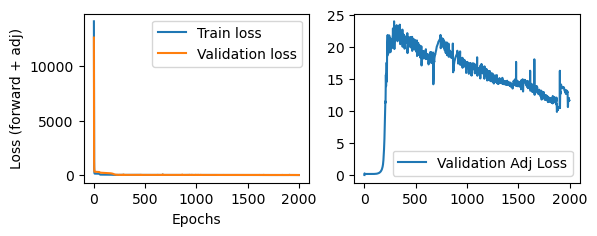

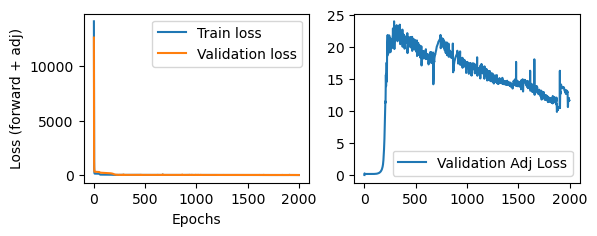

In [8]:
# viz training dynamics
import pickle 
with open('../logs/2023-07-14-11_logs.pkl', 'rb') as f:
    logger = pickle.load(f)
vis_train(logger=logger)

In [3]:
inputs.std(axis=0)[-3:]
from utils.plotter import Plotter

plotter = Plotter()

print(uout.min(), uout.max())
print(inputs.min(), inputs.max())
print(jrav.min(), jrav.max())




0.0 1773.939748633615
-4.999999256121194 1773.939748633615
-36.37509660888256 55.04949626260833


In [4]:

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
a = jnp.asarray(jrav, dtype=jnp.float64)
jnp.mean(a)

Array(-0.00852645, dtype=float64)

# Find out the most sensitive 5 parameters to match
Since the performance of adjoint matching NN is suboptimal for either all parameters including states or parameters only, we can start with simpler situtaitons.

We use $L_2$ norm of each **row** of the Jacobian to determine the most sensitive input parameters. 

In [7]:
# Find out the most sensitive parameters: top 5
from numpy.linalg import norm
norms = norm(jrav, axis=1)
normsMean = np.mean(norms, axis=0)
maxIdx = np.argsort(normsMean)[:5]
print('The most senstivie 5 parameters are', maxIdx)
# returns the last few states!

The most senstivie 5 parameters are [78 79 77 76 75]


dict_keys(['train_loss', 'train_adj_loss', 'val_loss', 'val_adj_loss', 'train_r2', 'val_r2', 'best_params', 'final_params'])
3.1832264e-05 2.7132108e-05


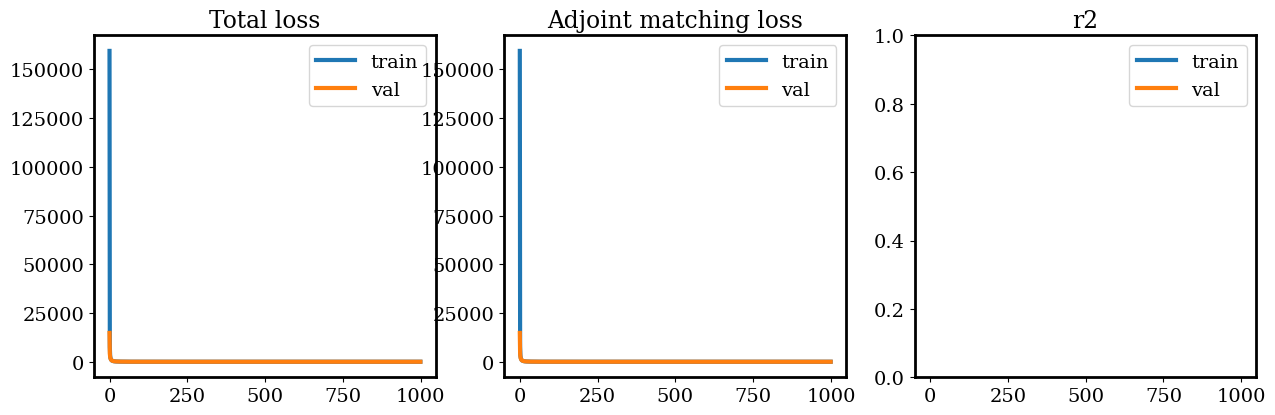

In [20]:
import matplotlib.pyplot as plt
import pickle

with open('./logs/logger_04-27-09_GlaicerStateJacOnly_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
print(logger.keys())
print(logger['train_adj_loss'][-1], logger['val_adj_loss'][-1])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(logger['train_loss'], label='train')
ax[0].plot(logger['val_loss'], label='val')
# ax[0].set_ylim(0, 1000)
ax[1].plot(logger['train_adj_loss'], label='train')
ax[1].plot(logger['val_adj_loss'], label='val')
ax[2].plot(logger['train_r2'], label='train')
ax[2].plot(logger['val_r2'], label='val')
ax[2].set_ylim(0,1)
ax[0].set_title('Total loss')
ax[1].set_title('Adjoint matching loss')
ax[2].set_title('r2')
for a in ax:
    a.legend()
    a.set_box_aspect(1)
# fig.savefig('./figs_adjoint/trainingCurve_mixed_nu.pdf', format='pdf')
plt.show()



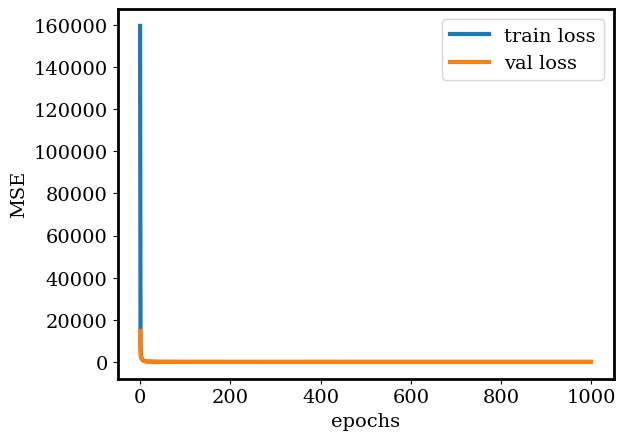

In [15]:
fig, ax = plt.subplots()
ax.plot(logger['train_loss'], label='train loss')
ax.plot(logger['val_loss'], label='val loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
# ax.set_ylim(-5, 200)
plt.legend()


In [23]:
from AdjointMatchJAX import MLP, Trainer
from utils.data_loader import split_data
from utils.metrics import mean_squared_error, r2
from utils.scaler import StandardScaler
import pickle
import optax
import numpy as np

# config.update("jax_enable_x64", True)

data = np.load('../data/vary_beta.dat_4-7-23.npz')
inputs = data['inputs']
uout = data['uout']
j_beta = data['jac_beta']
jrav = data['jac_u']
jrav = np.concatenate([jrav, j_beta[..., np.newaxis]], axis=-1)

with open('./logs/logger_04-27-09_GlaicerStateJacOnly_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)



train, val, test = split_data(inputs, uout, jrav, shuffle_all=True)
scaler = StandardScaler(train['x'])
x = test['x']
net = MLP([200]*5, in_dim=train['x'].shape[1], out_dim=train['y'].shape[1], act_fn='tanh', scaler=scaler)

params = logger['final_params']
test_pred = net.apply(params, x)
# test_pred = y_scaler.inverse_transform(test_pred)
pred_adj = net.full_Jacobian(params, inputs)
# pred_adj = adj_scaler.inverse_transform(pred_adj)

u_pred = net.apply(params, inputs)
# u_pred = y_scaler.inverse_transform(u_pred)


print('The test MSE is {:.4f}'.format(mean_squared_error(test['y'], test_pred)))
# print('The train MSE is {:.4f}'.format(mean_squared_error(train['y'], u_pred)))
print('The test R2 is {:.4f}'.format(r2(test['y'], test_pred)))
print('The test adj mse is {:.4f}'.format(mean_squared_error(jrav[..., :-1], pred_adj[..., :-1])))
print('The test adj R2 is {:4f}'.format(r2(jrav[..., :-1], pred_adj[..., :-1])))





The test MSE is 17344.1660
The test R2 is -0.6083
The test adj mse is 0.0000
The test adj R2 is -926147957227520.000000


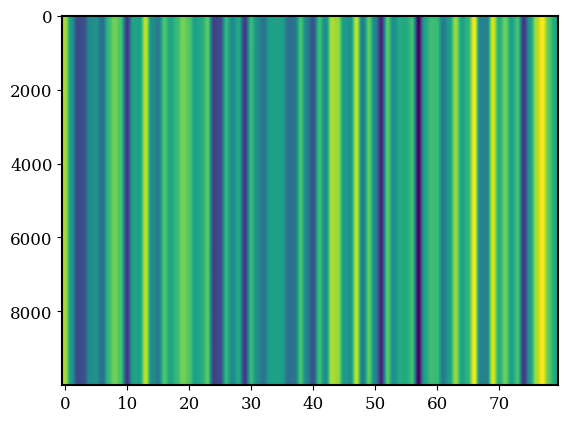

In [18]:
from utils.plotter import Plotter

plotter = Plotter()
# print(uout.shape)
# plotter.heat_map(uout[-5000:],test_pred)
plt.imshow(u_pred, aspect='auto')

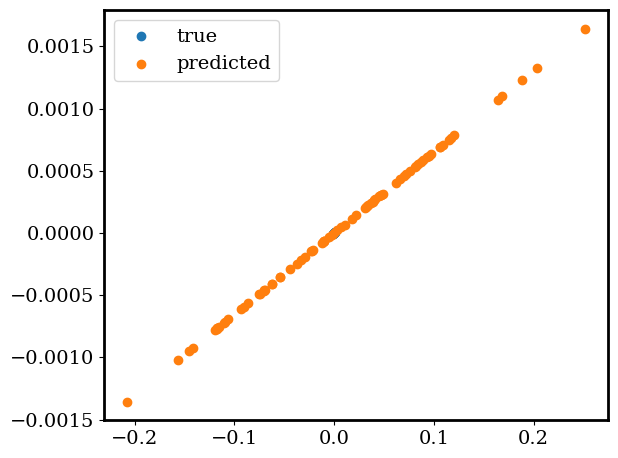

In [25]:
fig = plotter.pca_plot(test['adj'][...,:-1][3], pred_adj[...,:-1][3])
fig.savefig('../../../paper/figures/allAdjointOnly.pdf')